![CEE Masthead](http://kyrill.ias.sdsmt.edu/wjc/eduresources/CEE_284_Masthead.png)

# RESPEC Example of TMDLs of *Ecoli*

## Introduction




## Libraries

Let's start with the libraries

* [NumPy](https://docs.scipy.org/doc/NumPy/reference/routines.math.html) for some basic math functions
* [Pandas](https://pandas.pydata.org) Python Data Analysis Library
* [SciPy](https://docs.scipy.org/doc/scipy/reference/stats.mstats.html) for statistics
* [IterTools](https://docs.python.org/3/library/itertools.html) Functions creating iterators for efficient looping
* [DateTime](https://docs.python.org/3/library/datetime.html) a date-time support library
* [Matplotlib](https://matplotlib.org) for plotting




In [17]:
################################################
#
# Libraries
#

import numpy              as np
import pandas             as pd
import scipy.stats.mstats as scimstats
import itertools          as itls
import datetime           as dt
import matplotlib.pyplot  as plt

#
################################################

In [18]:
#from MPCA
datafilepath = 'http://kyrill.ias.sdsmt.edu/wjc/eduresources/RESPEC_TMDL_EXAMPLE/Data.csv'


In [19]:
#create using GIS (impaired reaches and available data for each impaired parm)
sitefilepath = 'http://kyrill.ias.sdsmt.edu/wjc/eduresources/RESPEC_TMDL_EXAMPLE/ObsEvalSites.csv'

In [20]:
#export using SARA, save as CSV, delete stats
simflowfilepath = 'http://kyrill.ias.sdsmt.edu/wjc/eduresources/RESPEC_TMDL_EXAMPLE/Flow.csv'


In [21]:
#Read Water Quality Data and TMDL Sites
df = pd.read_csv(datafilepath,index_col='SYS_LOC_CODE', encoding='unicode_escape')
sites = pd.read_csv(sitefilepath,index_col='SYS_LOC_CODE')
df['Date_F'] = pd.to_datetime(df['SAMPLEDATE'])
df['Month']=df['Date_F'].dt.month
df['Year']=df['Date_F'].dt.year
dfsites = pd.merge(df,sites,right_index=True, left_index=True)


In [22]:
TMDLStartYear = 2009
TMDLEndYear = 2018
EcoliStartMonth = 4
EcoliEndMonth = 10

In [23]:
EcoliStandardGeomean = 126
EcoliStandardDM = 1260

In [24]:
#Specify Standards
EcoliStandardMGM = pd.DataFrame({'Month':[1,12],'E. coli Geomean Standard (126 mpn/100mL)':[EcoliStandardGeomean,EcoliStandardGeomean]})
EcoliStandardMDM = pd.DataFrame({'Month':[1,12],'E. coli Daily Max Standard (1,260 mpn/100mL)':[EcoliStandardDM,EcoliStandardDM]})
EcoliStandardYGM = pd.DataFrame({'Year':[TMDLStartYear-1,TMDLEndYear+1],'E. coli Geomean Standard (126 mpn/100mL)':[EcoliStandardGeomean,EcoliStandardGeomean]})
EcoliStandardYDM = pd.DataFrame({'Year':[TMDLStartYear-1,TMDLEndYear+1],'E. coli Daily Max Standard (1,260 mpn/100mL)':[EcoliStandardDM,EcoliStandardDM]})


In [25]:
#Pull Seasonal E.coli Data from File
Ecoli = dfsites[dfsites['CHEMICAL_NAME'] == 'Escherichia coli']
EcoliAll = Ecoli[['Reach', 'Date_F', 'SAMPLE_TYPE_CODE', 'Month', 'Year', 'REPORT_RESULT_VALUE', 'Ecoli']]
EcoliTMDL = EcoliAll[EcoliAll['Ecoli'] == 'Y']
EcoliTMDL = EcoliTMDL.loc[EcoliTMDL['SAMPLE_TYPE_CODE'] == 'Sample']
EcoliSeasonal = EcoliTMDL[(EcoliTMDL.Month >= EcoliStartMonth) & (EcoliTMDL.Month <= EcoliEndMonth) & (EcoliTMDL.Year >= TMDLStartYear) & (EcoliTMDL.Year <= TMDLEndYear)]
EcoliSeasonalPlots = EcoliSeasonal.rename(columns = {'REPORT_RESULT_VALUE': 'E. coli (mpn/100mL)'})
EcoliSeasonalPlots['E. coli Standard (mpn/100mL)'] = EcoliStandardDM


In [26]:
#Read Simulated Flow, EXPORT FROM SARA, ADD 'r' TO BEGINNING OF REACH DATA, CHANGE TYPE TO NUMBER IN EXCEL!!!
SimFlow = pd.read_csv(simflowfilepath)
SimFlow['Date_F'] = pd.to_datetime(SimFlow['Date'])
SimFlow['Month']=SimFlow['Date_F'].dt.month
SimFlow['Year']=SimFlow['Date_F'].dt.year


In [27]:
#Convert Simulated Flow from ac-ft/day to cfs
SimFlow['r97']=SimFlow['r97']*43560/86400
SimFlow['r213']=SimFlow['r213']*43560/86400


In [28]:
##Sort flow by Impaired Reach and Calculate Percentiles for Flow Duration
##UPDATE Model Reach and TMDL Reach

Flow_505_Ecoli_temp=SimFlow.loc[(SimFlow.Month>= EcoliStartMonth) & (SimFlow.Month <= EcoliEndMonth) & (SimFlow.Year >=TMDLStartYear),('Date_F','r213','Month','Year')]
Flow_505_Ecoli=Flow_505_Ecoli_temp.sort_values('r213')
Flow_505_Ecoli['Rank_Pct']=Flow_505_Ecoli.r213.rank(pct=True)
Flow_505_Ecoli['Rank_Pct_Normalized'] = (1-Flow_505_Ecoli.Rank_Pct/Flow_505_Ecoli['Rank_Pct'].max())*100 
Flow_505_Ecoli['GM Loading Capacity'] = Flow_505_Ecoli['r213']*EcoliStandardGeomean*28316.8*86400/100
Flow_505_Ecoli['DM Loading Capacity'] = Flow_505_Ecoli['r213']*EcoliStandardDM*28316.8*86400/100
Flow_505_Ecoli['Reach'] = 505
Flow_505_Ecoli['Flow_Zone']='Very High'
Flow_505_Ecoli.loc[Flow_505_Ecoli['Rank_Pct_Normalized']>10, 'Flow_Zone'] = 'High'
Flow_505_Ecoli.loc[Flow_505_Ecoli['Rank_Pct_Normalized']>40, 'Flow_Zone'] = 'Mid'
Flow_505_Ecoli.loc[Flow_505_Ecoli['Rank_Pct_Normalized']>60, 'Flow_Zone'] = 'Low'
Flow_505_Ecoli.loc[Flow_505_Ecoli['Rank_Pct_Normalized']>90, 'Flow_Zone'] = 'Very Low'
Obs_505_Ecoli = pd.merge(Flow_505_Ecoli,EcoliSeasonalPlots, on=['Reach','Date_F'])
Obs_505_Ecoli['Observed Load (mpn/day)']= Obs_505_Ecoli['r213']*Obs_505_Ecoli['E. coli (mpn/100mL)']*28316.8*86400/100
Obs_505_Ecoli['Flow_Zone']='Very High'
Obs_505_Ecoli.loc[Obs_505_Ecoli['Rank_Pct_Normalized']>10, 'Flow_Zone'] = 'High'
Obs_505_Ecoli.loc[Obs_505_Ecoli['Rank_Pct_Normalized']>40, 'Flow_Zone'] = 'Mid'
Obs_505_Ecoli.loc[Obs_505_Ecoli['Rank_Pct_Normalized']>60, 'Flow_Zone'] = 'Low'
Obs_505_Ecoli.loc[Obs_505_Ecoli['Rank_Pct_Normalized']>90, 'Flow_Zone'] = 'Very Low'



In [29]:
Flow_507_Ecoli_temp=SimFlow.loc[(SimFlow.Month>= EcoliStartMonth) & (SimFlow.Month <= EcoliEndMonth) & (SimFlow.Year >=TMDLStartYear),('Date_F','r97','Month','Year')]
Flow_507_Ecoli=Flow_507_Ecoli_temp.sort_values('r97')
Flow_507_Ecoli['Rank_Pct']=Flow_507_Ecoli.r97.rank(pct=True)
Flow_507_Ecoli['Rank_Pct_Normalized'] = (1-Flow_507_Ecoli.Rank_Pct/Flow_507_Ecoli['Rank_Pct'].max())*100
Flow_507_Ecoli['GM Loading Capacity'] = Flow_507_Ecoli['r97']*EcoliStandardGeomean*28316.8*86400/100
Flow_507_Ecoli['DM Loading Capacity'] = Flow_507_Ecoli['r97']*EcoliStandardDM*28316.8*86400/100
Flow_507_Ecoli['Reach'] = 507
Flow_507_Ecoli['Flow_Zone']='Very High'
Flow_507_Ecoli.loc[Flow_507_Ecoli['Rank_Pct_Normalized']>10, 'Flow_Zone'] = 'High'
Flow_507_Ecoli.loc[Flow_507_Ecoli['Rank_Pct_Normalized']>40, 'Flow_Zone'] = 'Mid'
Flow_507_Ecoli.loc[Flow_507_Ecoli['Rank_Pct_Normalized']>60, 'Flow_Zone'] = 'Low'
Flow_507_Ecoli.loc[Flow_507_Ecoli['Rank_Pct_Normalized']>90, 'Flow_Zone'] = 'Very Low'
Obs_507_Ecoli = pd.merge(Flow_507_Ecoli,EcoliSeasonalPlots, on=['Reach','Date_F'])
Obs_507_Ecoli['Observed Load (mpn/day)']= Obs_507_Ecoli['r97']*Obs_507_Ecoli['E. coli (mpn/100mL)']*28316.8*86400/100
Obs_507_Ecoli['Flow_Zone']='Very High'
Obs_507_Ecoli.loc[Obs_507_Ecoli['Rank_Pct_Normalized']>10, 'Flow_Zone'] = 'High'
Obs_507_Ecoli.loc[Obs_507_Ecoli['Rank_Pct_Normalized']>40, 'Flow_Zone'] = 'Mid'
Obs_507_Ecoli.loc[Obs_507_Ecoli['Rank_Pct_Normalized']>60, 'Flow_Zone'] = 'Low'
Obs_507_Ecoli.loc[Obs_507_Ecoli['Rank_Pct_Normalized']>90, 'Flow_Zone'] = 'Very Low'


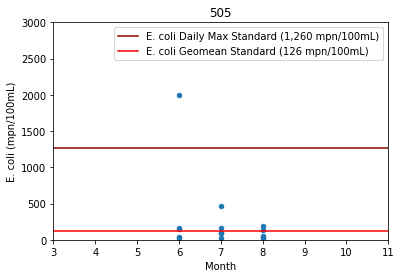

In [30]:
#Make Plots 
#Ecoli Monthly Plots
for i, group in EcoliSeasonalPlots.groupby('Reach'):  
    ax = group.plot.scatter(x='Month',y='E. coli (mpn/100mL)', grid=True, title=str(i))
    EcoliStandardMDM[['Month', 'E. coli Daily Max Standard (1,260 mpn/100mL)']].plot(x='Month',ax=ax,c='DarkRed')
    EcoliStandardMGM[['Month', 'E. coli Geomean Standard (126 mpn/100mL)']].plot(x='Month',ax=ax,c='Red')
    ax.set_ylim(0,3000)
    ax.set_xlim(EcoliStartMonth-1,EcoliEndMonth+1)
    plt.show()


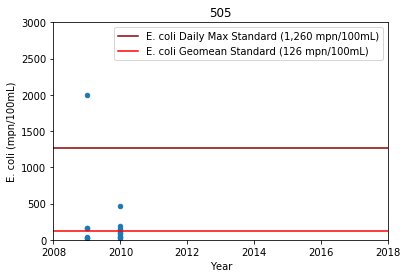

In [31]:
#Ecoli Annual Plots
for i, group in EcoliSeasonalPlots.groupby('Reach'):  
    ax = group.plot.scatter(x='Year',y='E. coli (mpn/100mL)', grid=True, title=str(i))
    EcoliStandardYDM[['Year', 'E. coli Daily Max Standard (1,260 mpn/100mL)']].plot(x='Year',ax=ax,c='DarkRed')
    EcoliStandardYGM[['Year', 'E. coli Geomean Standard (126 mpn/100mL)']].plot(x='Year',ax=ax,c='Red')
    ax.set_ylim(0,3000)
    ax.set_xlim(TMDLStartYear-1,TMDLEndYear)
    plt.show()


In [34]:
#Ecoli Stats 
EcoliStatsMonth = EcoliSeasonalPlots.groupby(['Reach', 'Month'])['E. coli (mpn/100mL)'].describe(percentiles=[.5,.9,.95])
EcoliStatsYear = EcoliSeasonalPlots.groupby(['Reach', 'Year'])['E. coli (mpn/100mL)'].describe(percentiles=[.5,.9,.95])
EcoliStatsMonth.to_csv('./Table/sEcoliStatsMonth.csv')
EcoliStatsYear.to_csv('./Table/EcoliStatsYear.csv')
EcoliSeasonalPlots.to_csv('./Table/EcoliSeasonalData.csv')

EcoliCurrent505flow = Flow_505_Ecoli.groupby(['Flow_Zone'])['r213'].describe(percentiles=[.5,.9,.95])
EcoliCurrent507flow = Flow_507_Ecoli.groupby(['Flow_Zone'])['r97'].describe(percentiles=[.5,.9,.95])

EcoliCurrent505flow.to_csv('./Table/EcoliCurrent505Flow.csv')
EcoliCurrent507flow.to_csv('./Table/EcoliCurrent507Flow.csv')

GroupedEcoliMonth = EcoliSeasonalPlots.groupby(['Reach', 'Month'])
GmeanEcoliMonth= GroupedEcoliMonth['E. coli (mpn/100mL)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliMonth.to_csv('./Table/EcoliGmeanMonth.csv')
GroupedEcoliYear = EcoliSeasonalPlots.groupby(['Reach', 'Year'])
GmeanEcoliYear= GroupedEcoliYear['E. coli (mpn/100mL)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliYear.to_csv('./Table/EcoliGmeanYear.csv')

GroupedEcoliCurrent505 = Obs_505_Ecoli.groupby(['Reach','Flow_Zone'])
GmeanEcoliCurrent505 = GroupedEcoliCurrent505['Observed Load (mpn/day)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliCurrent505Conc = GroupedEcoliCurrent505['E. coli (mpn/100mL)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliCurrent505.to_csv('./Table/EcoliEcoliGmeanCurrent505Load.csv')
GmeanEcoliCurrent505Conc.to_csv('./Table/EcoliGmeanCurrent505Conc.csv')

GroupedEcoliCurrent507 = Obs_507_Ecoli.groupby(['Reach','Flow_Zone'])
GmeanEcoliCurrent507 = GroupedEcoliCurrent507['Observed Load (mpn/day)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliCurrent507Conc = GroupedEcoliCurrent507['E. coli (mpn/100mL)'].apply(scimstats.gmean, axis=None).reset_index()
GmeanEcoliCurrent507.to_csv('./Table/EcoliGmeanCurrent507Load.csv')
GmeanEcoliCurrent507Conc.to_csv('./Table/EcoliGmeanCurrent507Conc.csv')


FileNotFoundError: [Errno 2] No such file or directory: './Table/sEcoliStatsMonth.csv'

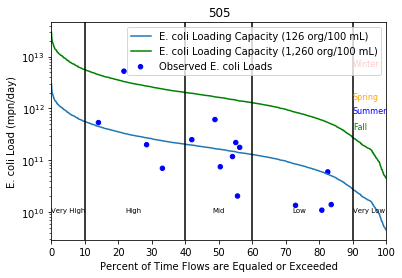

In [36]:
#Ecoli Load Duration Curves
colors= {1:'Red', 2:'Red', 3: 'Orange', 4:'Orange', 5:'Orange', 6:'Blue', 7:'Blue', 8:'Blue', 9:'Green', 10:'Green', 11:'Green', 12:'Red'}
ax = Flow_505_Ecoli.plot(kind='line', x='Rank_Pct_Normalized', y='GM Loading Capacity',title="505", logy=True, xlim=(0,100), xticks=[0,10,20,30,40,50,60,70,80,90,100], label = 'E. coli Loading Capacity (126 org/100 mL)')
Flow_505_Ecoli.plot(kind='line', x='Rank_Pct_Normalized', y='DM Loading Capacity',title="505", logy=True, xticks=[0,10,20,30,40,50,60,70,80,90,100], color='Green', ax=ax, label = 'E. coli Loading Capacity (1,260 org/100 mL)')
Obs_505_Ecoli.plot(kind='scatter', x='Rank_Pct_Normalized', y='Observed Load (mpn/day)',  c=[colors[i] for i in Obs_505_Ecoli['Month_x']], s=20, ax=ax, label = 'Observed E. coli Loads')
# ax.invert_xaxis()
ax.set_xlabel('Percent of Time Flows are Equaled or Exceeded')
ax.set_ylabel('E. coli Load (mpn/day)')
plt.axvline(x=10, color='Black')
plt.axvline(x=40, color='Black')
plt.axvline(x=60, color='Black')
plt.axvline(x=90, color='Black')
ax.legend(loc=1)
ax.text(0, 10000000000, 'Very High', fontsize=7)
ax.text(22, 10000000000, 'High', fontsize=7)
ax.text(48, 10000000000, 'Mid', fontsize=7)
ax.text(72, 10000000000, 'Low', fontsize=7)
ax.text(90, 10000000000, 'Very Low', fontsize=7)
ax.text(90, 6500000000000, 'Winter', fontsize=8, color='red')
ax.text(90, 1500000000000, 'Spring', fontsize=8, color='orange')
ax.text(90, 800000000000, 'Summer', fontsize=8, color='blue')
ax.text(90, 400000000000, 'Fall', fontsize=8, color='green')
plt.show()




## Version Information

In [ ]:
################################################################
#
# Loading Version Information
#

%load_ext version_information

%version_information version_information, numpy, scipy, matplotlib

#
################################################################